In [1]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback, CSVLogger, TensorBoard
from tensorflow.python.saved_model.loader_impl import parse_saved_model
from tensorflow.keras.losses import MSE, MeanAbsoluteError, BinaryCrossentropy
from modules.CustomLosses import LSSIM, L1AdversarialLoss, AdversarialLoss
from modules.misc import ssim_metric, get_model
from modules.DataMod import DataSet
from modules.TrainingManager import KerasTrainingManager
from os import environ
from typing import Callable
from ImageMetrics.metrics import three_ssim, psnrb
import numpy as np

environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
def LPSNRB (target_imgs, degraded_imgs):
    return -psnrb(target_imgs, degraded_imgs)

def L3SSIM (target_imgs, degraded_imgs):
    return 1-three_ssim(target_imgs, degraded_imgs)

In [4]:
model_ssim = get_model(model_json_name = "AutoEncoder-2.0-64x64.json")
model_3ssim = get_model(model_json_name = "AutoEncoder-2.0-64x64.json")

In [6]:
model_ssim.compile(
    optimizer = SGD(),
    loss = LSSIM(),
    metrics = [ssim_metric, psnrb, three_ssim]
)

model_3ssim.compile(
    optimizer = SGD(),
    loss = L3SSIM,
    metrics = [ssim_metric, psnrb, three_ssim]
)

In [3]:
dataset = DataSet().load_rafael_cifar_10_noise_data()

In [6]:
class MultipleTrainingLogger(Callback):
    """

    """
    def __init__(self, 
                 stop_fucntion: Callable[[list, str, Callable], bool],
                 metric_name: str,
                 dir_name: str = 'logs'
                   ):
        super(MultipleTrainingLogger, self).__init__()
        
        self.training_index: int 
        
        self.per_epoch_batch_results: dict = {}
        self.epoch_mean_results: dict = {}
        self.all_batch_results: dict = {}

        self.stop_function: Callable[[list, str, Callable], bool] = stop_fucntion
        self.metric_name: str = metric_name
        self.stoped_epoch: int = 0
        self.training_stoped: bool = False

        self.dir_name = dir_name
    
    # Geters

    def get_optimizer_kwargs(self) -> dict: 
        return self.model.optimizer.get_config()

    def get_model_name(self) -> str:
        return self.model.name

    def get_loss_kwargs(self) -> dict:
        pass


    # Operations

    def append_results(self, results_dict: dict, logs: dict):
        
        for metric_name, metric_value in logs.items():
            
            if not metric_name in results_dict:
                results_dict[metric_name] = []
            
            results_dict[metric_name].append(metric_value)

    def append_epoch_mean (self):

        for metric_name, metric_array in self.per_epoch_batch_results.items():
            
            metric_epoch_mean =  np.mean(metric_array, axis = 0)
            
            if not metric_name in self.epoch_mean_results:
                self.epoch_mean_results[metric_name] = []
            
            self.epoch_mean_results[metric_name].append(metric_epoch_mean)

    
    
    # Batch and epoch operations
    
    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        
        # clean epoch data
        self.per_epoch_batch_results: dict = {}
    
    def on_batch_end(self, batch, logs=None):
        
        self.append_results(self.per_epoch_batch_results, logs)
        self.append_results(self.all_batch_results, logs)
    
    def on_epoch_end(self, epoch, logs=None):
        
        self.append_epoch_mean()

        self.model.stop_training = self.stop_function(self.epoch_mean_results, self.metric_name)
        
        self.stoped_epoch = epoch
    
    def on_train_end(self, logs=None):
        return super().on_train_end(logs)
    


    

In [7]:
def stop_function (epoch_mean_results: dict, 
                   metric_name: str,
                   best_metric_selector = max,
                   min_percentual_variation = 0.02/100,
                   observation_window_lenght = 7) -> bool: 

    if len(epoch_mean_results[metric_name]) < observation_window_lenght + 1:
        return False
    
    best_window_result = best_metric_selector(epoch_mean_results[metric_name][-observation_window_lenght:])

    best_result_outside_window = best_metric_selector(epoch_mean_results[metric_name][:-observation_window_lenght])

    stop_signal = (best_window_result - best_result_outside_window)/best_result_outside_window < min_percentual_variation

    return stop_signal

In [7]:
#callback = MultipleTrainingLogger(stop_function, "ssim_metric")
model_ssim.fit(
    x = dataset.x_train,
    y = dataset.y_train,
    batch_size = 20,
    epochs = 50,
    validation_data = (dataset.x_test, dataset.y_test)
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

In [8]:
model_3ssim.fit(
    x = dataset.x_train,
    y = dataset.y_train,
    batch_size = 20,
    epochs = 40,
    validation_data = (dataset.x_test, dataset.y_test)
)

Epoch 1/40
2500/2500 [==============================] - 44s 16ms/step - loss: 0.5514 - ssim_metric: 0.4228 - psnrb: 14.7066 - three_ssim: 0.4486 - val_loss: 0.2895 - val_ssim_metric: 0.6637 - val_psnrb: 21.5583 - val_three_ssim: 0.7105
Epoch 2/40
2500/2500 [==============================] - 39s 15ms/step - loss: 0.2814 - ssim_metric: 0.6718 - psnrb: 20.7795 - three_ssim: 0.7186 - val_loss: 0.2586 - val_ssim_metric: 0.6989 - val_psnrb: 21.4150 - val_three_ssim: 0.7414
Epoch 3/40
2500/2500 [==============================] - 40s 16ms/step - loss: 0.2515 - ssim_metric: 0.7049 - psnrb: 21.6341 - three_ssim: 0.7485 - val_loss: 0.2332 - val_ssim_metric: 0.7243 - val_psnrb: 23.5970 - val_three_ssim: 0.7668
Epoch 4/40
2500/2500 [==============================] - 42s 17ms/step - loss: 0.2352 - ssim_metric: 0.7236 - psnrb: 22.1650 - three_ssim: 0.7648 - val_loss: 0.2275 - val_ssim_metric: 0.7323 - val_psnrb: 21.1133 - val_three_ssim: 0.7725
Epoch 5/40
2500/2500 [==============================] - 

In [11]:
imgs = [1, 200, 5000, 1200, 15]

ssim_imgs = np.clip(model_ssim.predict(dataset.x_test[imgs]), 0, 255)
ssim3_imgs = np.clip(model_3ssim.predict(dataset.x_test[imgs]), 0, 255)

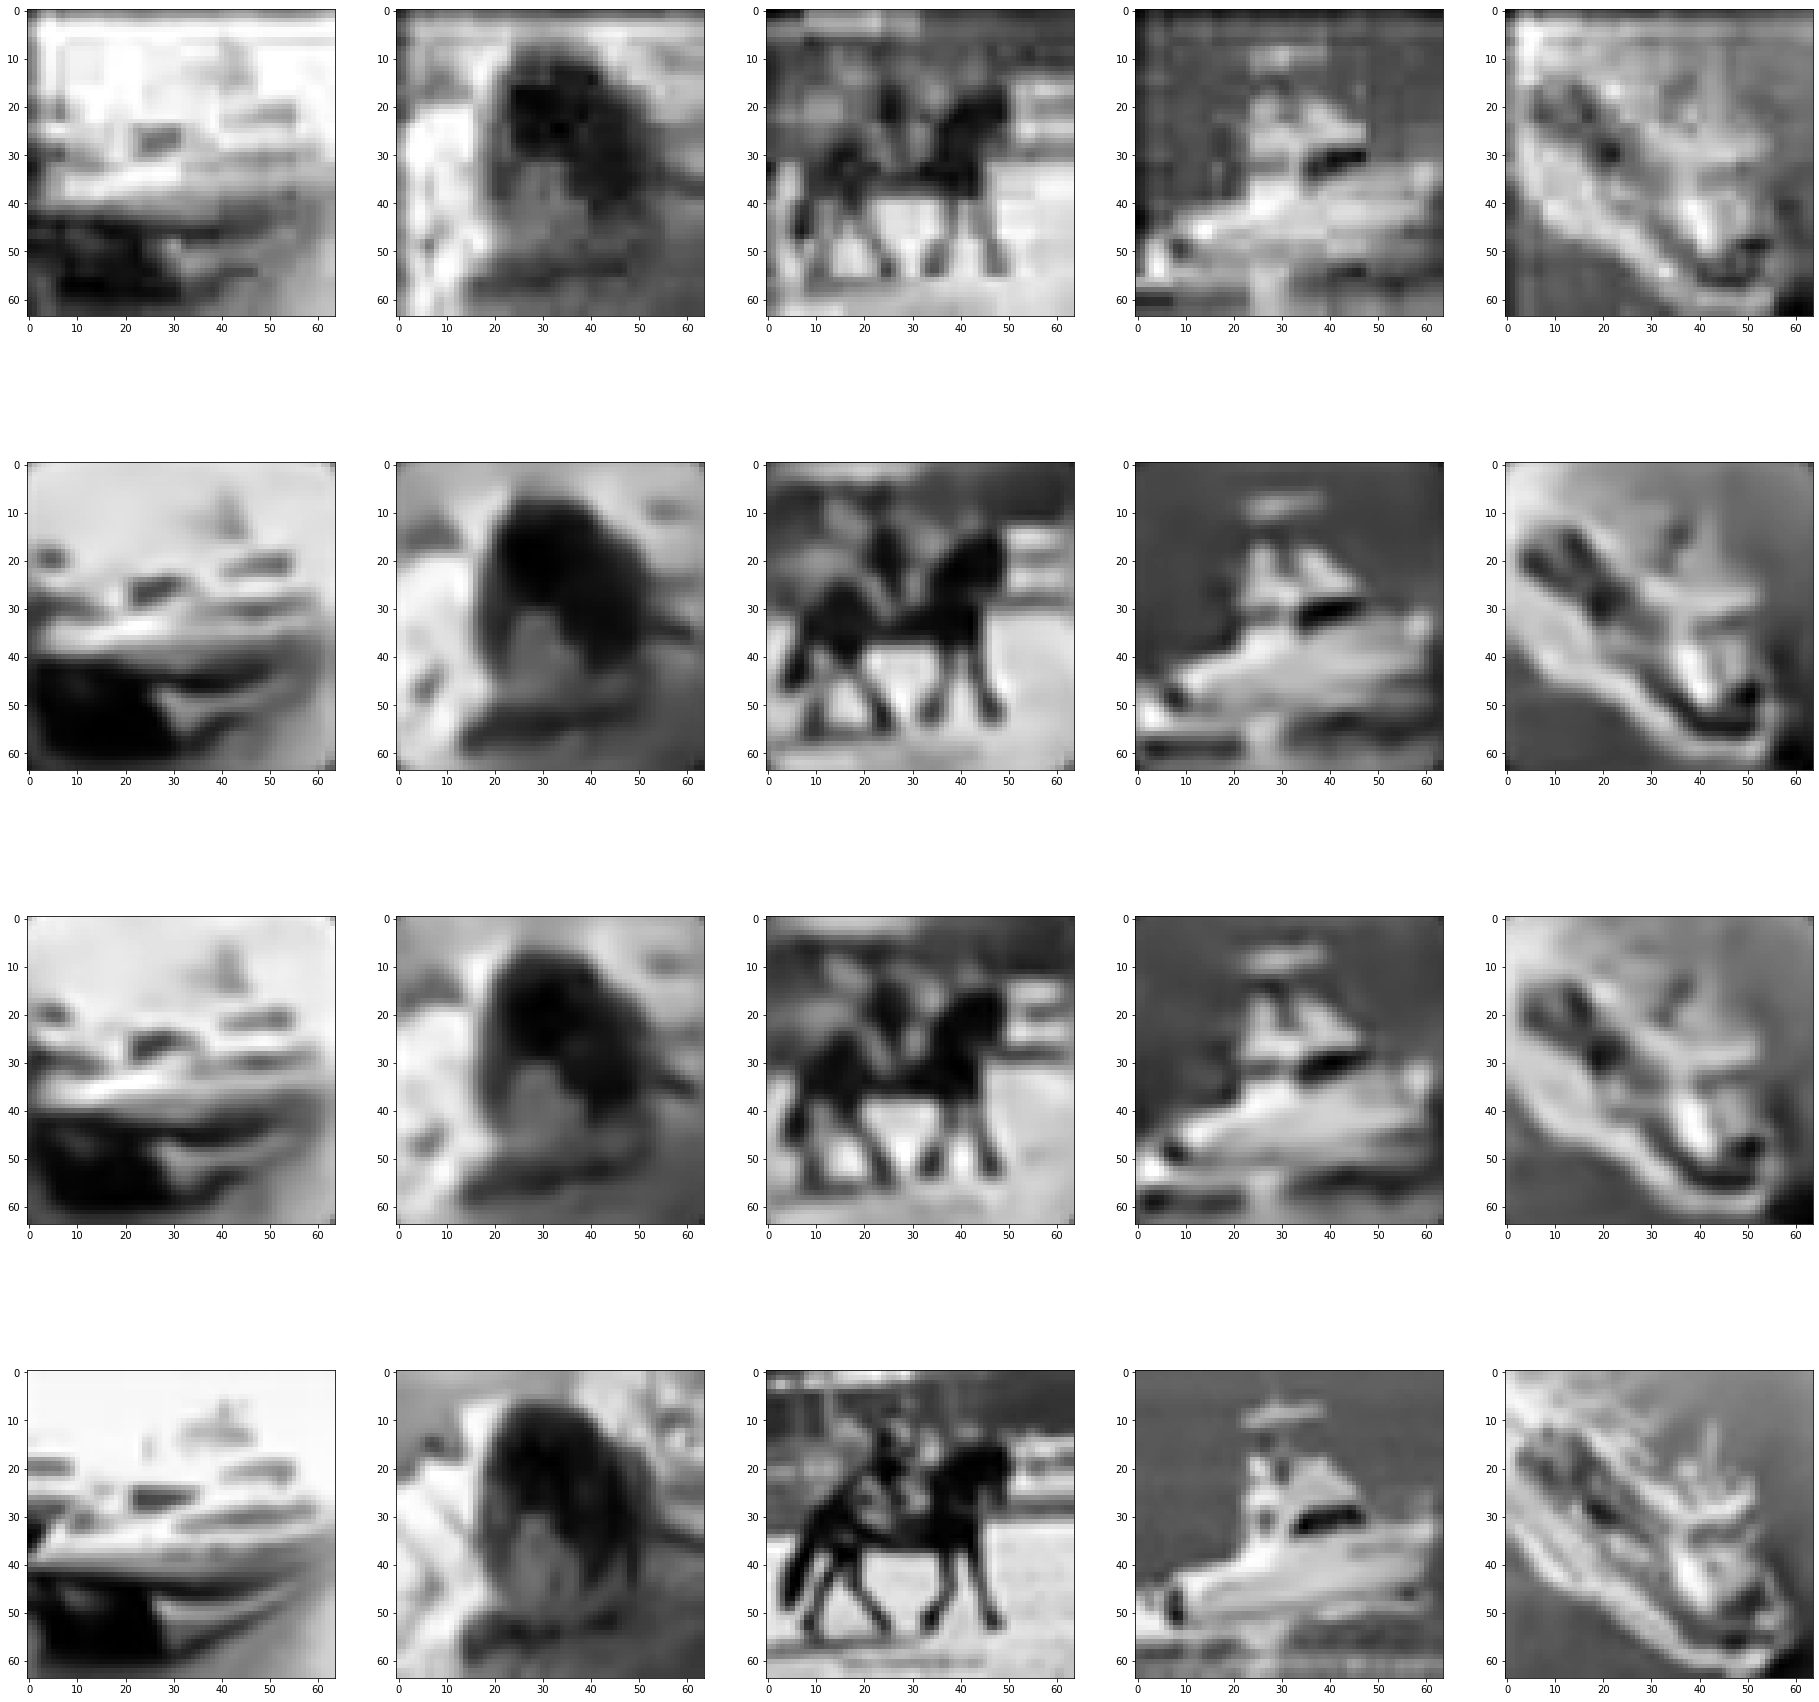

In [43]:
import matplotlib.pyplot as plt
#%matplotlib inline
imagens = np.concatenate((dataset.x_test[imgs], ssim_imgs, ssim3_imgs, dataset.y_test[imgs]))
fig = plt.figure(figsize=(32, 32))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imagens[i-1], cmap = "gray")
plt.show()